In [89]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from scipy import signal
import scipy.stats as stats
import cv2
import imutils
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1. From the entrance pupil to the PSF

Within the Fraunhofer framework, we simply have:

$PSF(x,y) = | \mathscr{F} [P(k,l) \; e^{i \phi(k,l)}] |^2$

$\mathscr{F}$ is the Fourier transform

$P(k,l)$ is the amplitude of the incoming wave - here the entrance pupil function (usually binary)

$\phi(k,l)$ is the phase of the incoming wave - here we assume a null phase for now (ideal case)

In the following we will do with a simple circular pupil (binary)

In [17]:
#Fonction to make a simple centered circular pupil
def mk_pupilc(radius,Nframe):
    P = np.zeros((Nframe,Nframe))#,dtype=complex)
    for k in range(Nframe):
            for m in range(Nframe):
                if pow((k-Nframe/2)*(k-Nframe/2)+(m-Nframe/2)*(m-Nframe/2),0.5) < radius:
                    P[k,m] = 1.0
    return P

In [67]:
#Fonction to make a circular pupil at a given position
def mk_pupil(radius, Nx, Ny, xc, yc):
    Mx = np.maximum(Nx,Ny)
    My = np.minimum(Nx,Ny)
    P = np.zeros((Nx,Ny))#, dtype='complex')
    for k in range(Mx):
            for m in range(My):
                if pow((k-xc)*(k-xc)+(m-yc)*(m-yc),0.5) < radius:
                    if Mx == Nx:
                        P[k,m] = 1.0
                    else: 
                        P[m,k] = 1.0
    return P

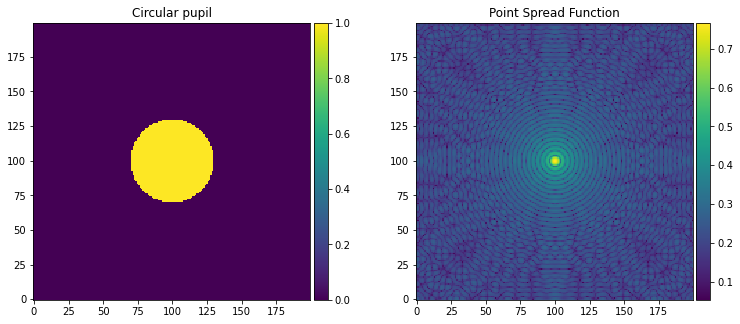

In [53]:
fig = plt.figure(1, figsize=(10,10))
gs = gridspec.GridSpec(1,2,height_ratios=[1], width_ratios=[1,1])
gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

Nframe = 200 #equivalent to varying the wavelength
Rpup = 30    #equivalent to varying pupil diameter
resolution = 1.22*apperture_dim/aperture_sz

#1- Definition pupil
pupil = mk_pupilc(Rpup, Nframe)
ax = plt.subplot(gs[0,0]) 
plt.title('Circular pupil')
im = ax.imshow(pupil, cmap='viridis', origin='lower',interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#2- Building the PSF
psf = np.abs(np.fft.fftshift(np.fft.fft2(pupil)))**2 
psf_norm = psf/np.sum(psf)
ax = plt.subplot(gs[0,1]) 
im = ax.imshow((psf_norm)**0.1, cmap='viridis', origin='lower', interpolation='nearest') 
plt.title('Point Spread Function')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


plt.show()

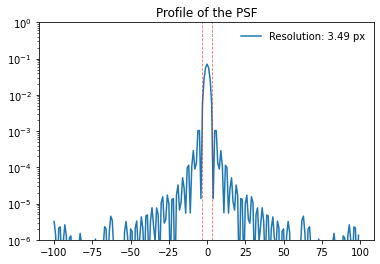

In [56]:
#3- Profile of the PSF
x_sup = np.arange(-apperture_dim//2,apperture_dim//2)
prof_psf = psf_norm[apperture_dim//2,:]
plt.title('Profile of the PSF')
plt.semilogy(x_sup,prof_psf,label='Resolution: {0:.2f} px'.format(resolution))
plt.axvline(x=resolution, color='r', ls = '--', lw=0.8, alpha=0.6)
plt.axvline(x=-resolution, color='r', ls = '--', lw=0.8, alpha=0.6)
#plt.xlim([0,Nframe//2])
plt.ylim([1/1e6,1.0])
plt.legend(frameon=False)

plt.show()

## 2. From the PSF to the OTF

Within the Fraunhofer framework, we have:

$OTF(u,v) = | \mathscr{F} [PSF(x,y)] |$

As we saw before, the Optical Transfert Function gives the content in terms of spatial frequencies.

At the center is the null spatial frequency (normalized to one).

It goes to zero at the cut-off frequency, the hoghest spatial frequency that the system can see.

-> this is the spatial filtering function of your instrument !

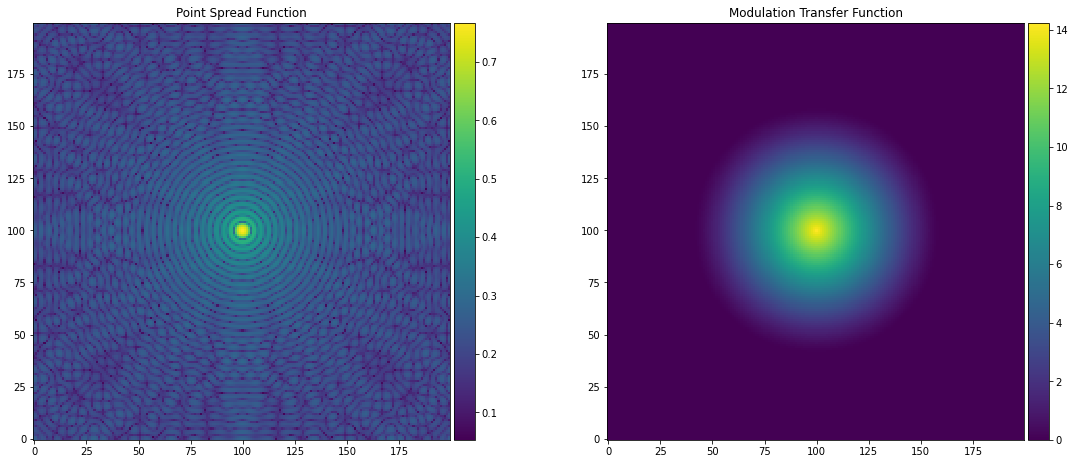

In [24]:
fig = plt.figure(1, figsize=(15,9))
gs = gridspec.GridSpec(1,2,height_ratios=[1], width_ratios=[1,1])
gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

#1- Showing the PSF
ax = plt.subplot(gs[0,0]) 
im = ax.imshow((psf_norm)**0.1, cmap='viridis', origin='lower', interpolation='nearest') 
plt.title('Point Spread Function')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#2- Building the OTF (actually the MTF beacause we take the abs())
otf_psf = np.fft.fftshift(np.fft.fft2(psf/np.max(psf)))
mtf_psf = np.abs(otf_psf)
ax = plt.subplot(gs[0,1]) 
im = ax.imshow(np.abs(otf_psf), cmap='viridis', origin='lower',interpolation='nearest')
plt.title('Modulation Transfer Function')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

Diameter of the entrance pupil: 60 px
Cutoff frequency from MTF: 59 px
Resolution from MTF: 3.389830508474576 px


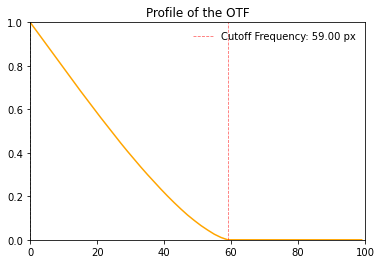

In [61]:
#3- Profile of the OTF
prof_otf_xdir = mtf_psf[apperture_dim//2,apperture_dim//2:]
cutoff_fcy = 1.
w = np.where(prof_otf_xdir < 1e-10, prof_otf_xdir, -1)
for i in range(np.shape(w)[0]):
    if w[i] != -1:
        cutoff_fcy=i
        break
otf_resolution = apperture_dim/cutoff_fcy

plt.title('Profile of the OTF')
plt.plot(x_sup[apperture_dim//2:],prof_otf_xdir/np.max(prof_otf_xdir),color='orange')
plt.ylim([0,1])
plt.xlim([0,apperture_dim/2])
plt.axvline(x=0, color='black', ls = '--', lw=0.8, alpha=0.6)
plt.axvline(x=cutoff_fcy, color='r', ls = '--', lw=0.8, alpha=0.6, \
            label='Cutoff Frequency: {0:.2f} px'.format(cutoff_fcy))
plt.legend(frameon=False)
    
print('Diameter of the entrance pupil:', Rpup*2, 'px')  
print('Cutoff frequency from MTF:', cutoff_fcy, 'px')        
print('Resolution from MTF:', otf_resolution, 'px')  

plt.show()

## 3. From the entrance Pupil to the OTF

Within the Fraunhofer framework, we have:

$OTF(\mathbf{k}) = \mathscr{A}utocorr [P(\mathbf{k})] = \int_{-\infty}^{\infty}  P^*(\mathbf{r}) P(\mathbf{r}+\mathbf{k}) d\mathbf{r} $


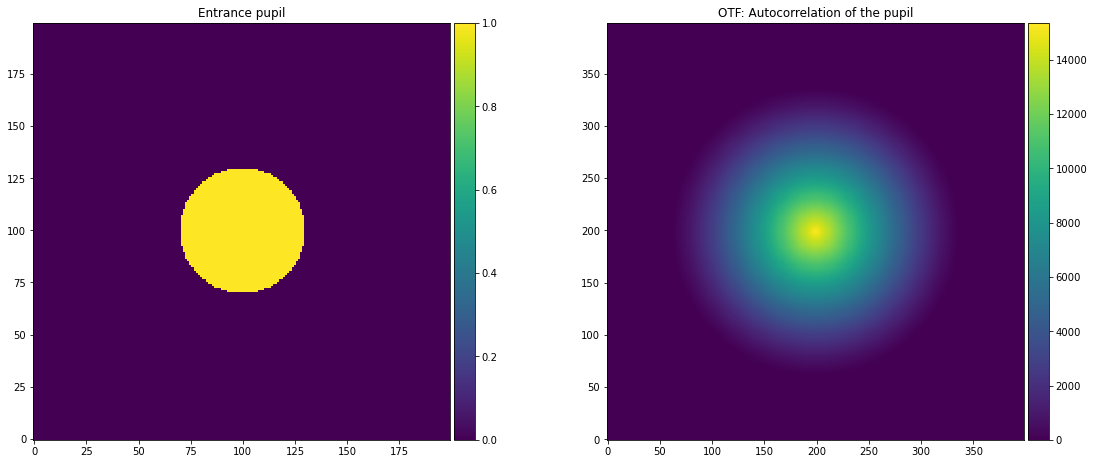

In [26]:
fig = plt.figure(1, figsize=(15,9))
gs = gridspec.GridSpec(1,2,height_ratios=[1], width_ratios=[1,1])
gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

#1- Showing the Pupil
ax = plt.subplot(gs[0,0]) 
im = ax.imshow(pupil, cmap='viridis', origin='lower', interpolation='nearest') 
plt.title('Entrance pupil')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#2- Building the OTF (actually the MTF beacause we take the abs()): 
#   Autocorrelation of the pupil
corr = signal.correlate2d(pupc, pupc)
ax = plt.subplot(gs[0,1]) 
im = ax.imshow(np.abs(corr), cmap='viridis', origin='lower',interpolation='nearest')
plt.title('OTF: Autocorrelation of the pupil')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [72]:
## 4. Putting it all together

2809.0
(14.239943040227839+0j)


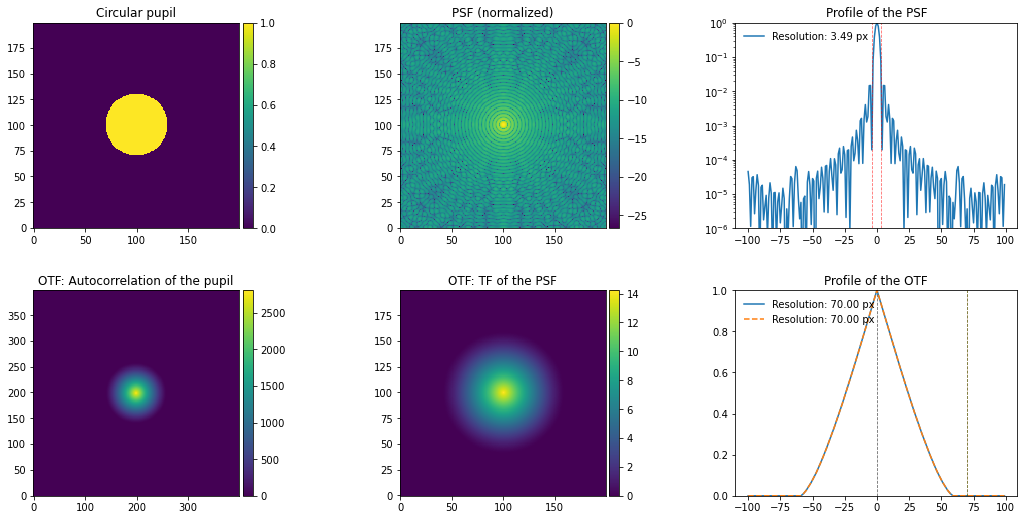

In [71]:
apperture_dim = 200 #equivalent to varying the wavelength
aperture_sz = 70    #equivalent to varying pupil diameter
resolution = 1.22*apperture_dim/aperture_sz
#note: minimum must be Npix // 2 else sampling problems in OTF from PSF :-)

fig = plt.figure(1, figsize=(15,9))
gs = gridspec.GridSpec(2,3,height_ratios=[1,1], width_ratios=[1,1,1])
gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

#0- Definition pupil
pupil = mk_pupilc(Rpup, Nframe)

pupc = pupil+1j*(pupil*0.)
ax = plt.subplot(gs[0,0]) 
plt.title('Circular pupil')
im = ax.imshow(pupil, cmap='viridis', origin='lower',interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#1- Autocorrelation of the pupil
corr = signal.correlate2d(pupc, pupc)
corr_real = np.real(corr)
ax = plt.subplot(gs[1,0]) 
im = ax.imshow(corr_real, cmap='viridis', origin='lower',interpolation='nearest')
plt.title('OTF: Autocorrelation of the pupil')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#2- Building the PSF 
psf = np.abs(np.fft.fftshift(np.fft.fft2(pupil)))**2 
psf_norm = psf/np.max(psf)
ax = plt.subplot(gs[0,1]) 
im = ax.imshow(np.log(psf_norm), cmap='viridis', origin='lower',interpolation='nearest')
plt.title('PSF (normalized)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#3- OTF via PSF
otf_psf = np.fft.fftshift(np.fft.fft2(psf/np.max(psf)))
mtf_psf = np.abs(otf_psf)
ax = plt.subplot(gs[1,1]) 
im = ax.imshow(np.abs(otf_psf), cmap='viridis', origin='lower',interpolation='nearest')
plt.title('OTF: TF of the PSF')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#4- Profile of the PSF
x_sup = np.arange(-apperture_dim//2,apperture_dim//2)
prof_psf = psf_norm[apperture_dim//2,:]
ax = plt.subplot(gs[0,2]) 
plt.title('Profile of the PSF')
ax.semilogy(x_sup,prof_psf,label='Resolution: {0:.2f} px'.format(resolution))
plt.legend(frameon=False)
plt.axvline(x=resolution, color='r', ls = '--', lw=0.8, alpha=0.6)
plt.axvline(x=-resolution, color='r', ls = '--', lw=0.8, alpha=0.6)
plt.ylim([1/1e6,1.0])

#6- Profile of the OTF from the PSF
prof_otf = mtf_psf[apperture_dim//2,:]
ax2 = plt.subplot(gs[1,2]) 
plt.title('Profile of the OTF')
#ax2.semilogx(x_sup,prof_otf,label='Resolution: {0:.2f} px'.format(aperture_sz))
ax2.plot(x_sup,prof_otf/np.max(prof_otf),label='Resolution: {0:.2f} px'.format(aperture_sz))
plt.legend(frameon=False)
#plt.xlim([1.0,apperture_dim//2])
plt.ylim([0,1])
plt.axvline(x=aperture_sz, color='r', ls = '--', lw=0.8, alpha=0.6)
plt.axvline(x=0, color='black', ls = '--', lw=0.8, alpha=0.6)

#6- Profile of the OTF from the autocorrelation
corr_real_crop = corr_real[(apperture_dim-1)//2:(apperture_dim)*3//2-1,(apperture_dim-1)//2:(apperture_dim)*3//2-1]
prof_acorr = corr_real_crop[apperture_dim//2,:]
ax2.plot(x_sup,prof_acorr/np.max(prof_acorr),label='Resolution: {0:.2f} px'.format(aperture_sz),ls='--')
plt.axvline(x=aperture_sz, color='g', ls = '--', lw=0.8, alpha=0.6)

plt.legend(frameon=False)

print(np.sum(pupil))
print(np.max(otf_psf))

-- **NOW we have seen the most important thing !!!** --

# Function to analyze any input pupil

In [62]:
#Function to make a circular profile
def mean_profile(image, step=1):
    x, y = np.shape(image)
    cc = np.shape(image)[0]//2
    newy, newx = np.mgrid[:y,:x]
    circ = np.sqrt((newx-cc)**2 + (newy-cc)**2)
    mean_ann = np.zeros(cc)
    for i in range(0,cc,step):
        circ_ext = np.where((circ < i+step), 1, 0)
        circ_int = np.where((circ >=  i), 1, 0)
        ann = circ_int*circ_ext
        idm = np.where(ann !=0)
        mean_ann[i]=np.mean(image[idm])
    return mean_ann

In [85]:
#Function to analyze any input pupil
def analyse_pupil(pupil, phase=1, Nimg= 0):
    fig = plt.figure(1, figsize=(15,9))
    gs = gridspec.GridSpec(2,3,height_ratios=[1,1], width_ratios=[1,1,1])
    gs.update(left=0.01, right=0.95, bottom=0.02, top=0.75, wspace=0.3, hspace=0.30)

    apperture_dim = np.shape(pupil)[0] #equivalent to varying the wavelength
    print('Size of frame:', apperture_dim, 'px')
    if np.size(phase) == 1:
        phase = np.zeros((apperture_dim,apperture_dim))
    pupil_complex = pupil * np.exp(1j*phase)
    if Nimg == 0:
        Nimg = apperture_dim//2
    
    #1- Display pupil complex: amplitude
    ax = plt.subplot(gs[0,0]) 
    plt.title('Input pupil: amplitude')
    im = ax.imshow(np.abs(pupil_complex), cmap='CMRmap', origin='lower',interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    #2- Display pupil complex
    ax = plt.subplot(gs[1,0]) 
    plt.title('Input pupil: phase')
    im = ax.imshow(np.angle(pupil_complex), cmap='CMRmap', origin='lower',interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    
    #3- Building the PSF 
    psf = np.abs(np.fft.fftshift(np.fft.fft2(pupil_complex)))**2 
    psf_norm = psf/np.max(psf)
    psf_crop = psf_norm[apperture_dim//2-Nimg//2:apperture_dim//2+Nimg//2,apperture_dim//2-Nimg//2:apperture_dim//2+Nimg//2]
    ax = plt.subplot(gs[0,1]) 
    im = ax.imshow((psf_crop)**0.1, cmap='CMRmap', origin='lower',interpolation='nearest')
    plt.title('PSF: |FT[pupil]|**2')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    #4- Profile of the PSF
    x_sup = np.arange(-apperture_dim//2,apperture_dim//2)
    prof_psf_xdir = psf_norm[apperture_dim//2,apperture_dim//2:]
    prof_psf_ydir = psf_norm[apperture_dim//2:,apperture_dim//2]
    prof_psf_circ = mean_profile(psf_crop)
    for psf_resolution in range(apperture_dim//2):
        if prof_psf_circ[psf_resolution+1] > prof_psf_circ[psf_resolution]:
            break
    print('Resolution from PSF:', psf_resolution, 'px')        
   
    ax = plt.subplot(gs[0,2]) 
    plt.title('Profile of the PSF')
    ax.semilogy(x_sup[apperture_dim//2:apperture_dim//2+Nimg//2],prof_psf_circ)
    plt.axvline(x=psf_resolution, color='r', ls = '--', lw=0.8, alpha=0.6, \
                label='Resolution PSF: {0:.2f} px'.format(psf_resolution))
    plt.xlim([0,Nimg//2])
    plt.ylim([1/1e6,1.0])
    plt.legend(frameon=False)

    
    #5- MTF (via PSF)
    otf_psf = np.fft.fftshift(np.fft.fft2(psf_norm))
    otf_norm = otf_psf/np.max(otf_psf)
    mtf_psf = np.abs(otf_norm)
    ax = plt.subplot(gs[1,1]) 
    im = ax.imshow(mtf_psf, cmap='CMRmap', origin='lower',interpolation='nearest')
    plt.title('MTF: |FT[PSF]|')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    #5- Phase (via PSF)
    #phase_psf = np.angle(otf_psf)
    #ax = plt.subplot(gs[1,2]) 
    #im = ax.imshow(phase_psf, cmap='CMRmap', origin='lower',interpolation='nearest')
    #plt.title('OTF: arg{FT[PSF]}')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(im, cax=cax)

    #6- Profile of the OTF from the PSF
    prof_otf_xdir = mtf_psf[apperture_dim//2,apperture_dim//2:]
    prof_otf_ydir = mtf_psf[apperture_dim//2:,apperture_dim//2]
    prof_otf_circ = mean_profile(mtf_psf)
    cutoff_fcy = 1.
    w = np.where(prof_otf_circ < 1e-10, prof_otf_circ, -1)
    for i in range(np.shape(w)[0]):
        if w[i] != -1:
            cutoff_fcy=i
            break
    otf_resolution = apperture_dim/cutoff_fcy
    print('Cutoff frequency from MTF:', cutoff_fcy, 'px')        
    print('Resolution from MTF:', otf_resolution, 'px')        
    ax = plt.subplot(gs[1,2]) 
    plt.title('Profile of the OTF')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_xdir/np.max(prof_otf_xdir), ls = '--',color='orange')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_ydir/np.max(prof_otf_ydir), ls = '--',color='orange')
    ax.plot(x_sup[apperture_dim//2:],prof_otf_circ/np.max(prof_otf_circ),color='green')
    plt.ylim([0,1])
    plt.xlim([0,apperture_dim/2])
    plt.axvline(x=0, color='black', ls = '--', lw=0.8, alpha=0.6)
    plt.axvline(x=cutoff_fcy, color='r', ls = '--', lw=0.8, alpha=0.6, \
                label='Cutoff Frequency: {0:.2f} px'.format(cutoff_fcy))
    plt.legend(frameon=False)



# 1. Full pupil aperture

## 1.1 Simple binary circular aperture

Size of frame: 512 px
Resolution from PSF: 5 px
Cutoff frequency from MTF: 128 px
Resolution from MTF: 4.0 px


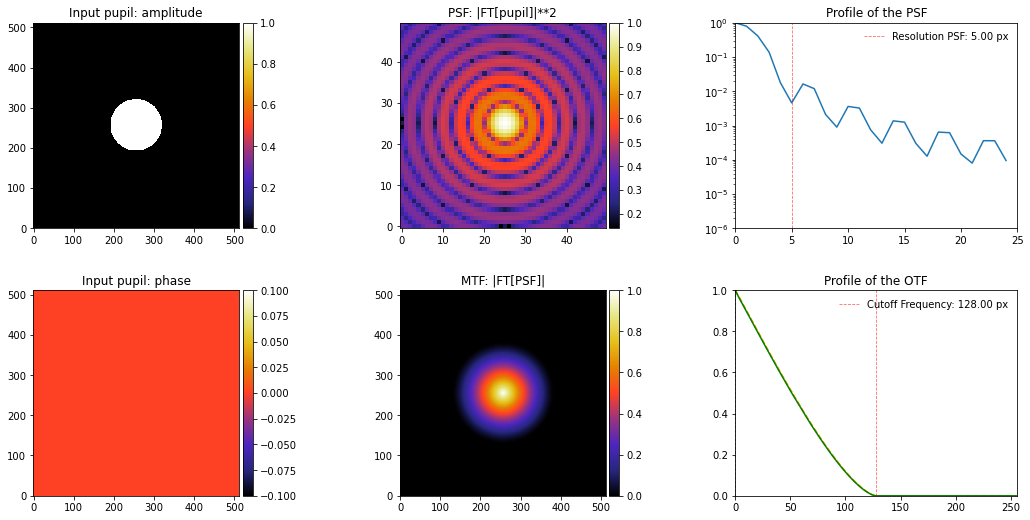

In [86]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 64    #equivalent to varying pupil diameter

pupil = mk_pupilc(apperture_radius,frame_size)
analyse_pupil(pupil,Nimg=50)

## 1.2 Simple binary circular aperture + central obstruction

Size of frame: 512 px
Resolution from PSF: 5 px
Cutoff frequency from MTF: 128 px
Resolution from MTF: 4.0 px


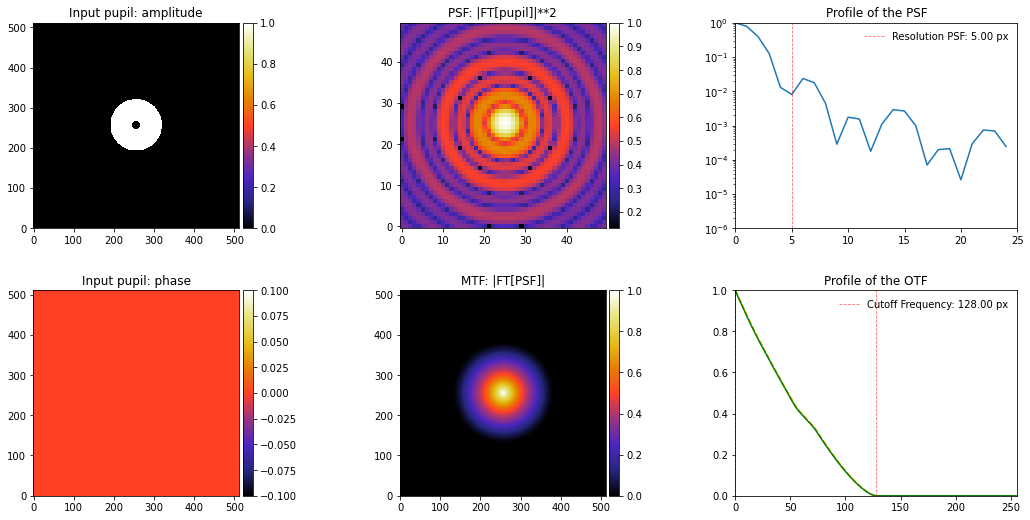

In [87]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 64    #equivalent to varying pupil diameter
obstruction_radius = 10  #equivalent to varying central obstruction

pupil_ext = mk_pupilc(apperture_radius,frame_size)
pupil_int = mk_pupilc(obstruction_radius,frame_size)
pupil_occ = (1-pupil_int)*pupil_ext

analyse_pupil(pupil_occ,Nimg=50)

## 1.3 VLT-UT3 pupil 

Size of frame: 1272 px
Resolution from PSF: 4 px
Cutoff frequency from MTF: 384 px
Resolution from MTF: 3.3125 px


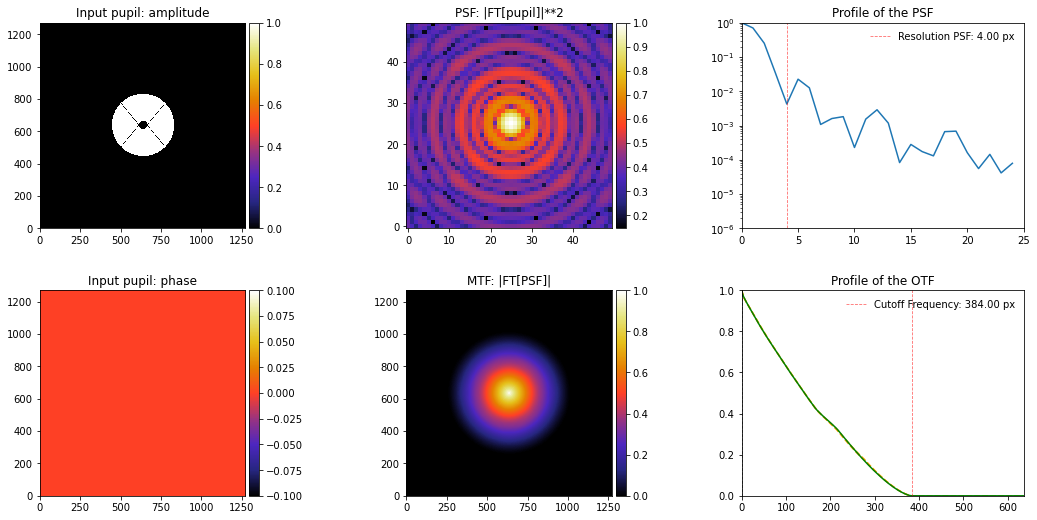

In [91]:
dir_pup = Path('/Users/fcantalloube/Work/Wind_Driven_Halo/SPHERE_info/Pupils_384x384_pixcentral/')
pupille_vlt = fits.getdata(dir_pup.joinpath('VLT_UT3_Pupil.fits'))

Nframe = 1272 #1306
Npupr = np.shape(pupille_vlt)[0]
frame_vlt = np.zeros((Nframe,Nframe))
frame_vlt[Nframe//2-Npupr//2:Nframe//2+Npupr//2,Nframe//2-Npupr//2:Nframe//2+Npupr//2] = pupille_vlt

analyse_pupil(frame_vlt,Nimg=50)

## 1.4 VLT-SPHERE pupil 

Size of frame: 1272 px
Resolution from PSF: 4 px
Cutoff frequency from MTF: 374 px
Resolution from MTF: 3.4010695187165774 px


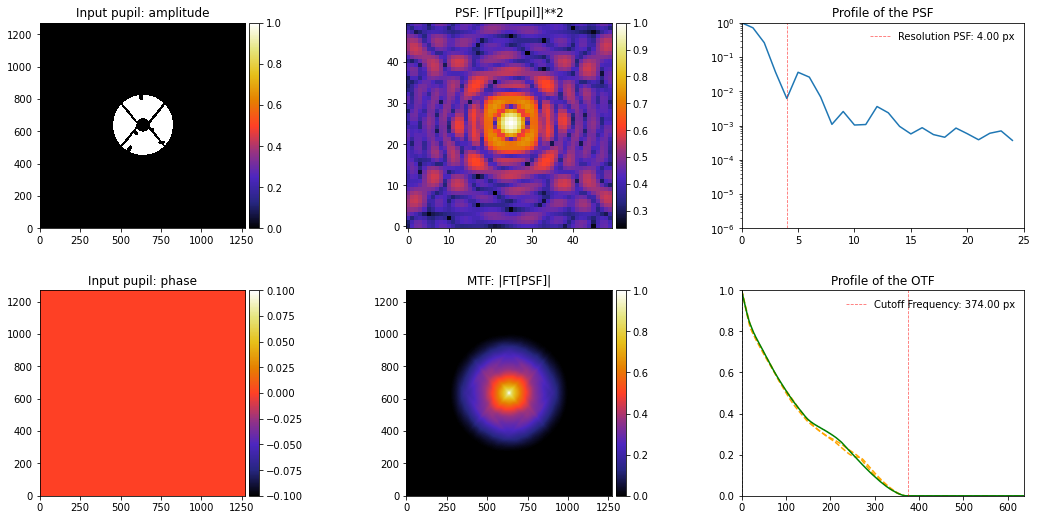

In [97]:
pupille_sph = fits.getdata(dir_pup.joinpath('ALC2LyotStop_measured.fits'))

Nframe = 1272 #1306
Npupr = np.shape(pupille_sph)[0]
frame_sph = np.zeros((Nframe,Nframe))
frame_sph[Nframe//2-Npupr//2:Nframe//2+Npupr//2,Nframe//2-Npupr//2:Nframe//2+Npupr//2] = pupille_sph

analyse_pupil(frame_sph,Nimg=50)

## 1.5 VLT-UT3 pupil + apodizer

Size of frame: 1272 px
Resolution from PSF: 4 px
Cutoff frequency from MTF: 384 px
Resolution from MTF: 3.3125 px


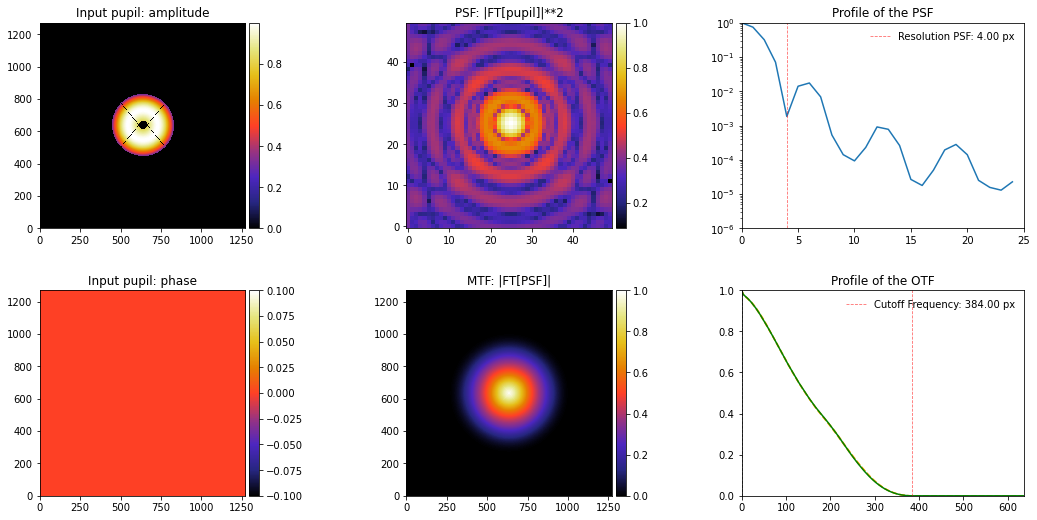

In [104]:
apodizer_sph = fits.getdata(dir_pup.joinpath('APO1Apodizer_measured_NoAmplError.fits'))

Nframe = 1272 #1306
Npupr = np.shape(apodizer_sph)[0]
frame_apo = np.zeros((Nframe,Nframe))
frame_apo[Nframe//2-Npupr//2:Nframe//2+Npupr//2,Nframe//2-Npupr//2:Nframe//2+Npupr//2] = pupille_vlt*apodizer_sph
#plt.imshow(apodizer_sph)

analyse_pupil(frame_apo,Nimg=50)

# 2. Interferometry

## 2.1 Two holes

Size of frame: 512 px
Resolution from PSF: 7 px
Cutoff frequency from MTF: 20 px
Resolution from MTF: 25.6 px


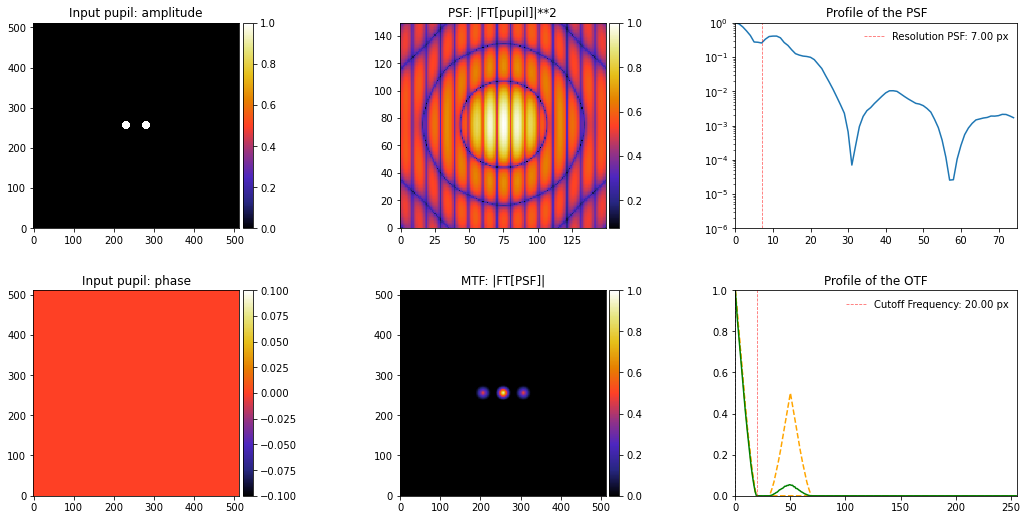

In [117]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 10    #sub-pupil diameter
baseline = 50            #distance between sub-pupils

sub_pupil1 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2-baseline//2)
sub_pupil2 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2+baseline//2)
pupil_all = sub_pupil1 + sub_pupil2
#plt.imshow(pupil_all)

analyse_pupil(pupil_all,Nimg=150)

## 2.2 Three+ holes redundant

Size of frame: 512 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 20 px
Resolution from MTF: 25.6 px


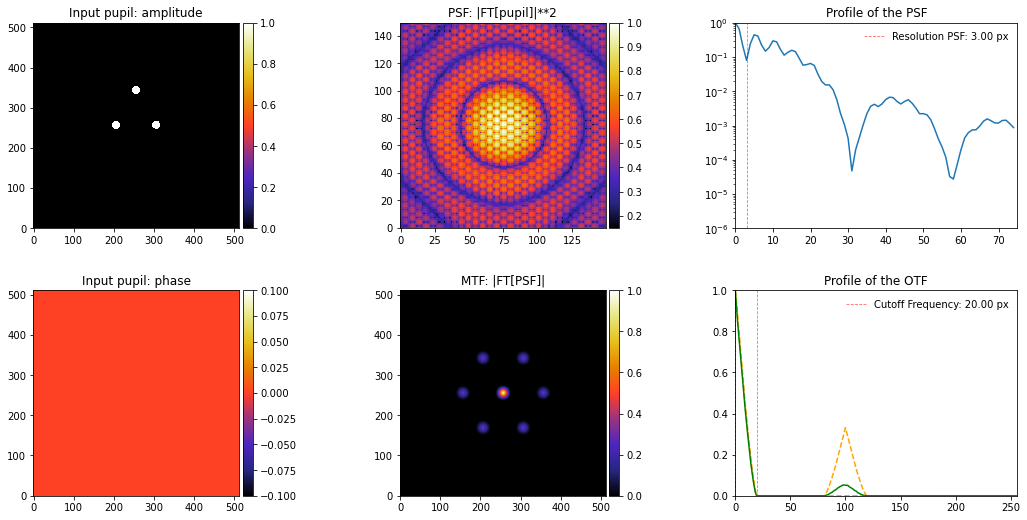

In [128]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 10    #sub-pupil diameter
baseline = 100            #distance between sub-pupils

sub_pupil1 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2-baseline//2)
sub_pupil2 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2+baseline//2)
sub_pupil3 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+baseline//2*np.sqrt(3), frame_size//2)
sub_pupil4 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2-baseline//2*np.sqrt(3), frame_size//2)
pupil_all = sub_pupil1 + sub_pupil2 + sub_pupil3 #+ sub_pupil4
#plt.imshow(pupil_all)

analyse_pupil(pupil_all,Nimg=150)

## 2.3 Three+ holes non-redundant

Size of frame: 512 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 20 px
Resolution from MTF: 25.6 px
Number of baselines 6.0


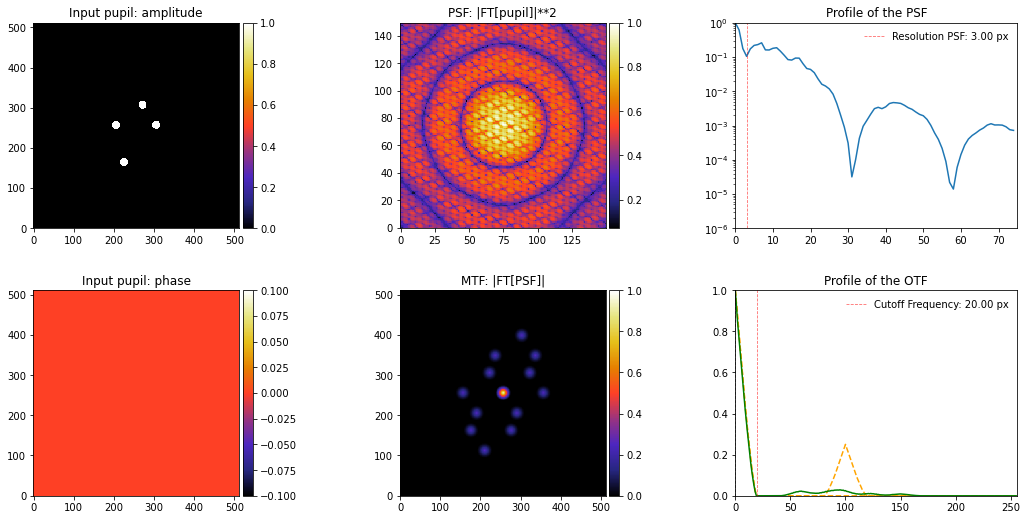

In [140]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 10    #sub-pupil diameter
baseline = 100            #distance between sub-pupils

sub_pupil1 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2-baseline//2)
sub_pupil2 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2+baseline//2)
sub_pupil3 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+50, frame_size//2+16)
sub_pupil4 = mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2-93, frame_size//2-30)
pupil_all = sub_pupil1 + sub_pupil2 + sub_pupil3 + sub_pupil4
#plt.imshow(pupil_all)

analyse_pupil(pupil_all,Nimg=150)

N = 4
print('Number of baselines', N*(N-1)/2)

## 2.4 SPHERE-SAM mask

Design for the VLT: 7-holes (21 baselines) mask, as for former NaCo instrument (see Lacour+2011 and Cheetham+2016)

Measured on IRDIS

Size of frame: 1024 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 357 px
Resolution from MTF: 2.8683473389355743 px


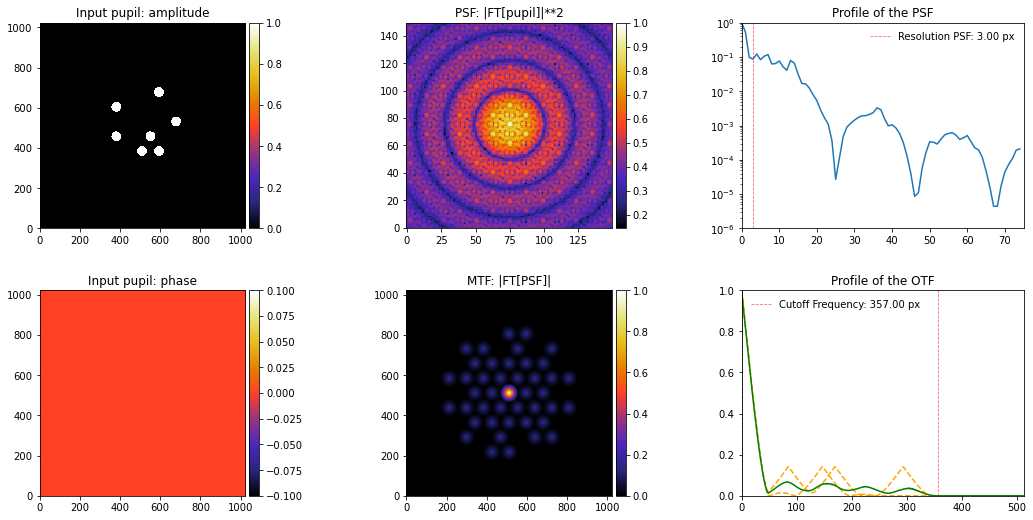

In [166]:
sph_sam = fits.getdata(dir_pup.joinpath('SAM_IRDIS_binary.fits'))
analyse_pupil(sph_sam,Nimg=150)

## 2.5 More and more holes

Size of frame: 1024 px
Resolution from PSF: 5 px
Cutoff frequency from MTF: 356 px
Resolution from MTF: 2.8764044943820224 px


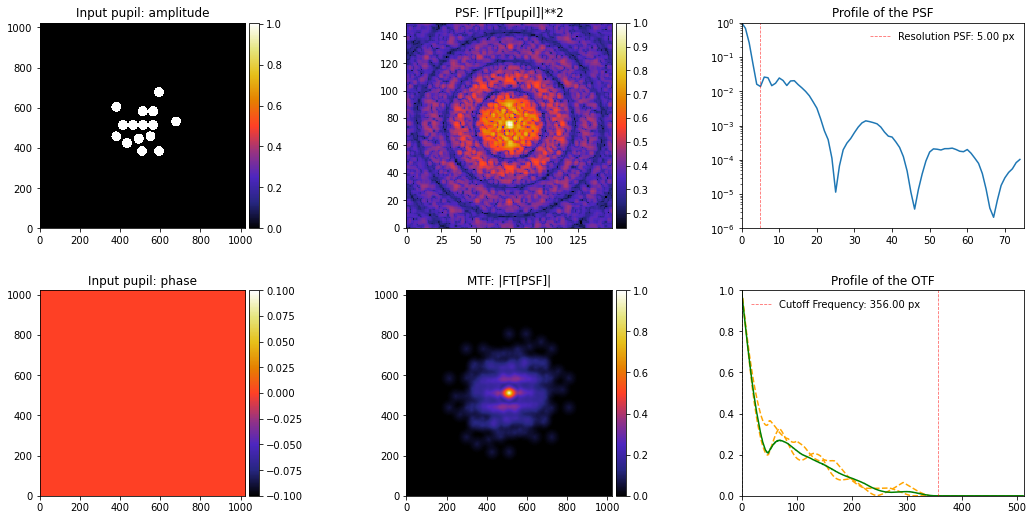

In [208]:
frame_size = 1024
apperture_radius = 25
pup_weirdo = sph_sam+mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2-baseline//2)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2+baseline//2)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+68, frame_size//2+baseline//2)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+68, frame_size//2+baseline//2-52)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2-68, frame_size//2+baseline//2-72)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2-90, frame_size//2-80)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2)
pup_weirdo += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2-100)

#plt.imshow(pup_weirdo)

analyse_pupil(pup_weirdo,Nimg=150)

Size of frame: 1024 px
Resolution from PSF: 4 px
Cutoff frequency from MTF: 393 px
Resolution from MTF: 2.6055979643765905 px


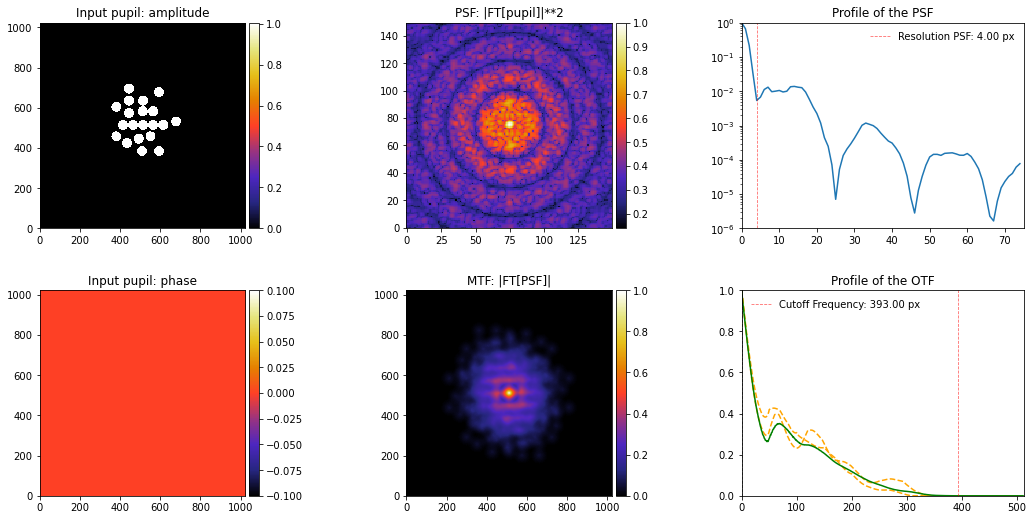

In [214]:
frame_size = 1024
apperture_radius = 25
pup_weirdo2 = pup_weirdo + mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2, frame_size//2+100)
pup_weirdo2 += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+120, frame_size//2)
pup_weirdo2 += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+120, frame_size//2-70)
pup_weirdo2 += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+180, frame_size//2-70)
pup_weirdo2 += mk_pupil(apperture_radius, frame_size, frame_size, frame_size//2+60, frame_size//2-70)

#plt.imshow(pup_weirdo2)

analyse_pupil(pup_weirdo2,Nimg=150)

## 2.6 Linking full aperture with sparse aperture

Size of frame: 512 px
Resolution from PSF: 3 px
Cutoff frequency from MTF: 128 px
Resolution from MTF: 4.0 px


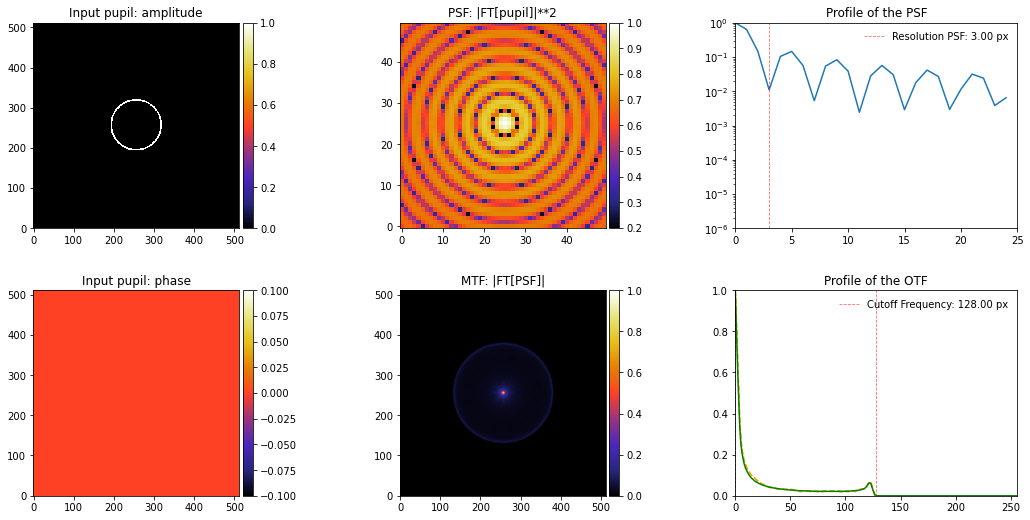

In [167]:
frame_size = 512         #equivalent to varying the wavelength
apperture_radius = 64    #equivalent to varying pupil diameter
obstruction_radius = 60  #equivalent to varying central obstruction

pupil_ext = mk_pupilc(apperture_radius,frame_size)
pupil_int = mk_pupilc(obstruction_radius,frame_size)
pupil_occ = (1-pupil_int)*pupil_ext

analyse_pupil(pupil_occ,Nimg=50)